In [1]:
from Bio.PDB import PDBParser
import pandas as pd
import re
import os
import subprocess

# import from ../utils.py
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import get_dbref_data

c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## 1. simple visualisation (network and cartoon) 
### still need to simplify

In [7]:
from matplotlib import pyplot as plt
import pickle

def get_ca_coordinates(pdb_file):
    # get x, y, z coordinates of alpha carbon atoms
    parser = PDBParser()
    structure = parser.get_structure("pdb_structure", pdb_file)
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] == ' ':
                    for atom in residue:
                        if atom.get_id() == 'CA':
                            coords = atom.get_coord()
                            ca_atoms.append({
                                'residue_number': residue.id[1],
                                'amino_acid': residue.resname,
                                'chain': chain.id,
                                'x': coords[0],
                                'y': coords[1],
                                'z': coords[2],
                            })
    return ca_atoms

def get_res_info(res):
    def check_residue_format(string):
        # Define the pattern for the format "<3letteraa><res_num><chain>"
        pattern = r'^[a-zA-Z]{3}\d+[a-zA-Z]$'
        
        # Check if the string matches the pattern
        if re.match(pattern, string):
            return True
        else:
            return False
    aas, res_nums, chains = [], [], []
    for r in res:
        # should have format "<3letteraa><res_num><chain>"
        if not check_residue_format(r):
            print()
            aas.append("NA")
            res_nums.append("NA")
            chains.append("NA")
            continue
        # get amino acid, residue number and chain
        aas.append(r[:3])
        res_nums.append(int(r[3:-1]))
        chains.append(r[-1])
    return aas, res_nums, chains



def save_palette_img(filename, palette, binvalues):
    """
    Print and display the generated color palette.

    Parameters:
    palette (list): List of RGB tuples representing the color palette.
    """
    fig, ax = plt.subplots(figsize=(10, 1), nrows=1, ncols=1)
    for idx, color in enumerate(palette):
        ax.add_patch(plt.Rectangle((idx, 0), 1, 1, color=color))
    
    ax.set_xlim(0, len(palette))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    # add bin values
    for idx, val in enumerate(binvalues):
        ax.text(idx+0, 1.1, f"{val:.2f}", color='black', ha='center', va='center', fontsize=8)

    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [26]:
def create_pymol_script(score_file_path, score_file_path_score_col, pdb_id, uniprot, pdb_file_path, palette="RdBu", score_file_path_chain_col=None, reverse_color=False, meaningful_zero=True):

    ca_coordinates = pd.DataFrame(get_ca_coordinates(pdb_file_path))
    ca_coordinates['foo_name'] = ["foo"+str(i) for i in range(1, len(ca_coordinates) + 1)]
    ca_coordinates['atom_name'] = ["atom"+str(i) for i in range(1, len(ca_coordinates) + 1)]

    out = "bg_color white\n"
    for _, row in ca_coordinates.iterrows():
        out += f"pseudoatom {row['foo_name']}, pos=[{row['x']}, {row['y']}, {row['z']}], name={row['atom_name']}\n"
        out += f"set grid_slot, 1, {row['foo_name']}\n"
        out += f"set grid_slot, 1, {row['atom_name']}\n"

    with open (f"../sbna_results/{pdb_id}/A/{pdb_id}_multimer/Centroid/{pdb_id}_multimer_nowaters_centroidNetSC", "r") as f:
        res1 = []
        res2 = []
        dist = []
        for line in f:
            res1.append(line.split()[0])
            res2.append(line.split()[1])
            dist.append(line.split()[-1])
    tmp = pd.DataFrame()
    tmp['res1'] = res1
    tmp['res2'] = res2
    tmp['dist'] = dist

    # --> there are duplicates where res1 and res2 are just swapped

    # Create a new column with sorted node pairs
    tmp['sorted_nodes'] = tmp.apply(lambda row: sorted([row['res1'], row['res2']]), axis=1)
    tmp.drop_duplicates(subset='sorted_nodes', inplace=True) # Drop duplicates based on sorted node pairs
    tmp = tmp.drop(columns=['sorted_nodes']).reset_index(drop=True)

    tmp['aa1'], tmp['res_num1'], tmp['chain1'] = get_res_info(tmp['res1'])
    tmp['aa2'], tmp['res_num2'], tmp['chain2'] = get_res_info(tmp['res2'])

    tmp = tmp.merge(ca_coordinates, left_on=['res_num1', 'aa1', 'chain1'], right_on=['residue_number', 'amino_acid', 'chain'], how='left')
    tmp.rename(columns={'x': 'x1', 'y': 'y1', 'z': 'z1', 'foo_name': 'foo_name1', 'atom_name': 'atom_name1'}, inplace=True)

    tmp = tmp.merge(ca_coordinates, left_on=['res_num2', 'aa2', 'chain2'], right_on=['residue_number', 'amino_acid', 'chain'], how='left')
    tmp.rename(columns={'x': 'x2', 'y': 'y2', 'z': 'z2', 'foo_name': 'foo_name2', 'atom_name': 'atom_name2'}, inplace=True)

    count = 1

    for _, row in tmp.iterrows():
        bond = "b"+str(count)
        out += f"create {bond}, {row['foo_name1']} or {row['foo_name2']}\n"
        out += f"bond {bond}////{row['atom_name1']}, {bond}////{row['atom_name2']}\n"
        out += f"set grid_slot, 1, {bond}\n"
        count += 1

    out += 'delete '
    for i in ca_coordinates['foo_name']:
        out += i + ' or '
    out = out[:-3]
    out += '\n'
    
    out += "set grid_mode, 1\n"
    out += f"fetch {pdb_id}\n"
    out += f"set grid_slot, 2, {pdb_id}\n"

    out += f"copy {pdb_id}_copy, {pdb_id}\n"
    out += f"set grid_slot, 1, {pdb_id}_copy\n"

    out += f"hide everything, {pdb_id}_copy\n"
    out += f"show spheres, name ca and {pdb_id}_copy\nset sphere_scale, 0.25, (all)\n"

    out += f"show cartoon, {pdb_id}_copy\n"
    out += f"set cartoon_transparency, 0.85, {pdb_id}_copy\n"

    cmd = f"python pdb_color_generic_v3.py -c {str(score_file_path_score_col)} -d , -p {pdb_file_path} -i {score_file_path} -l {palette} -s {uniprot} "
    if score_file_path_chain_col:
        cmd += f"--chain-column {str(score_file_path_chain_col)} "
    if not meaningful_zero:
        cmd += "-z "
    if reverse_color:
        cmd += "-r "
    
    script_args = cmd.strip().split(' ')
    print(script_args)
    out += subprocess.run(script_args, capture_output=True, text=True).stdout

    # read palette file
    with open('palette.pkl', 'rb') as file:
        palette = pickle.load(file)
    save_palette_img(f"data/{pdb_id}_palette_network_score.png", palette[0], palette[1])

    # recolour bonds, since they are overwritten by the pdb_color_generic script
    count = 1
    for _, row in tmp.iterrows():
        bond = "b"+str(count)
        out += f"color grey70, {bond}\n"
        count += 1

    return out

c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6715.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6716.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6717.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 6718.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6719.
  warnings.warn(
c:\Users\liyoa\anaconda3\envs\sbna\Lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is d

['python', 'pdb_color_generic_v3.py', '-c', '1', '-d', ',', '-p', '../pdb_files/2OCJ.pdb', '-i', 'data/2OCJ_network_score.csv', '-l', 'RdBu', '-s', 'P53_HUMAN', '--chain-column', '2', '-z', '-r']


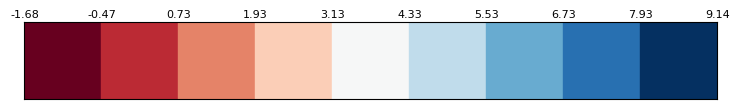

In [28]:
# pdb = "6GOD"

# # cmd = f"python pdb_color_generic_v3.py -c 1 -d , -p data/{pdb_id}/{pdb_id}.pdb -i data/{pdb_id}/{pdb_id}_ns.csv -l div1w -s {unp} --chain-column 2 -z 0"
# score_file_path = "data/2OCJ/2OCJ_ns.csv"
score_file_path_score_col = 1
score_file_path_chain_col = 2
pdb_id = "2OCJ"
uniprot = "P53_HUMAN"
score_filepath = f"data/{pdb_id}_network_score.csv"
pdb_file_path = f"../pdb_files/{pdb_id}.pdb"
# ipt(score_file_path, score_file_path_score_col, pdb_id, uniprot, pdb_file_path, palette="RdBu", score_file_path_chain_col=None, reverse_color=False, meaningful_zero=True)
script = create_pymol_script(score_filepath, score_file_path_score_col, pdb_id, uniprot, pdb_file_path, palette="RdBu", score_file_path_chain_col=2, reverse_color=True, meaningful_zero=False)

# write script to file
with open(f"scripts/{pdb_id}_test.pml", "w") as f:
    f.write(script)

## WT and mut comparison (it works!!!)

In [24]:
pdb1 = "1UNR" # wild type (not required, can also be swapped with pdb2)
pdb2 = "2UZR" # mutant 
# pdb1 = "6GOD"
# pdb2 = "6GOE"
# unp = "KRAS_HUMAN"

ns_data = pd.read_csv("../lung_cancer/lung_genes_sbna.csv")
ns_data = ns_data[ns_data['pdb_id'].isin([pdb1, pdb2])]
ns_data[['pdb_id', 'chain', 'uniprot_num', 'network_score']].to_csv(f"data/{pdb1}_{pdb2}_network_score.csv", index=False)

out = f"""bg_color white
set grid_mode, 1
fetch {pdb1}
fetch {pdb2}
align (chain A & {pdb1}), (chain A & {pdb2})
zoom (chain A & {pdb1})
remove resn HOH
"""
# python pdb_color_generic_v4_comparison.py -c 3 -d "," -i data/6GOD_6GOE/6GOD_6GOE_network_score.csv -l RdBu -r -s KRAS_HUMAN --chain-column 2 -z --pdb-column 0 --site-column 1
script_args = f"python pdb_color_generic_v4_comparison.py -c 3 -d , -i data/{pdb1}_{pdb2}_network_score.csv -l RdBu -r -s {unp} -z --pdb-column 0 --chain-column 1 --site-column 2".split(' ')
out += subprocess.run(script_args, capture_output=True, text=True).stdout

# delete the file
os.remove(f"data/{pdb1}_{pdb2}_network_score.csv")

print(out)

bg_color white
set grid_mode, 1
fetch 1UNR
fetch 2UZR
align (chain A & 1UNR), (chain A & 2UZR)
zoom (chain A & 1UNR)
remove resn HOH
set_color colordefault, [0.9657054978854287,0.9672433679354094,0.9680891964628989]
color colordefault, all
set_color RdBu_a, [0.02,0.188,0.38]
set_color RdBu_b, [0.127,0.396,0.669]
set_color RdBu_c, [0.263,0.576,0.765]
set_color RdBu_d, [0.566,0.769,0.869]
set_color RdBu_e, [0.82,0.898,0.941]
set_color RdBu_f, [0.966,0.967,0.968]
set_color RdBu_g, [0.992,0.859,0.78]
set_color RdBu_h, [0.955,0.642,0.506]
set_color RdBu_i, [0.839,0.376,0.302]
set_color RdBu_j, [0.692,0.092,0.168]
set_color RdBu_k, [0.404,0.0,0.122]
color colordefault, 1UNR & chain A
color colordefault, 2UZR & chain A
select a_grp_1_A, ((1UNR & chain A & resi 18,19,20,21,23,67,68,70))
color RdBu_a, a_grp_1_A
select b_grp_2_A, ((1UNR & chain A & resi 13,17,24,39,40,49,61,65,66,78,80,81,82,85,91,92,93,94,119,120) or (2UZR & chain A & resi 18,19,23,67,108,109,112,115,116,117,118,120))
color RdB